# **Superconductivity Regression Notebook**
Analyzes feature data from "*../data/supercon_features.csv*", which is produced in *get_featurizers.ipynb*. This is used to provide insight and guide optimzation of machine learning models created in the training notebooks. The machine learning models predict the critical temputure of superconductors.

*Author: Kirk Kleinsasser*

## Import Libraries / Define Import Data Function

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #confidence intervals for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as Superlearner

[MLENS] backend: threading


In [53]:
def analysis(): #makes a heatmap that shows correlations between features and targets, saves to '../data/feature_heatmap.png'
    global corr_matrix
    sfn.import_data(replace_inf=True) #import data with function above

    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(['HOMO_character','HOMO_element', 'LUMO_character', 'LUMO_element'], axis=1, inplace=True) #drop columns irrelevant to analysis
    graph_data['target'] = sfn.target.values #add target back in

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    fig, ax = plt.subplots(figsize=(36, 36), dpi = 480) #define figure and sizing features
    ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.color_palette("Spectral", as_cmap=True))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.tick_params(colors='grey', which='both') #set various colors

    #save heatmap
    figure = ax.get_figure()    
    figure.savefig('../data/feature_heatmap.png', dpi=480) #saves to '../data/feature_heatmap.png' at 480 dpi

    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#1e1e1e'}):
        graph_data.hist(bins=50, figsize=(25,25))
        plt.savefig("../data/attribute_histogram_plots.png")
        plt.show()
# analysis() #calls function

def get_poorcorr(threshold=0.1):
    assert 1.0 > threshold >= 0, "Threshold must be greater than or equal to 0 and less than 1.0"
    sfn.import_data(replace_inf=True) #import data with function above
    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(['HOMO_character','HOMO_element', 'LUMO_character', 'LUMO_element'], axis=1, inplace=True) #drop columns irrelevant to analysis
    graph_data['target'] = sfn.target.values #add target back in

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    target_corr = corr_matrix['target'] #gets target
    poor_corr = target_corr[(target_corr > -threshold) & (target_corr < threshold)]
    return poor_corr.index.values

In [60]:
poor_corr = get_poorcorr(0.05)

## Setup Arguments and Models

In [61]:
sfn.import_data(replace_inf=True)
#defines the arguments for each model
RFR_ARGS = {}
SP_ARGS = {'X': sfn.train_data}
KNN_ARGS = {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}
TREES_ARGS = {}
LIN_ARGS = {}

#defines the models in a list of pairs of lists. The first item in a pair is the top graph in a column, the second is the bottom. The last item of a model is to enable uncert calc
models  =  ((("Unoptimized Linear Regression", LinearRegression, {}, True),               ("Linear Regression", LinearRegression, LIN_ARGS, True)),
            (("Unoptimized Random Forest Regression", RandomForestRegressor, {}, True),   ("Random Forest Regression", RandomForestRegressor, RFR_ARGS, True)),
            (("Unoptimized Extra Trees Regression", ExtraTreesRegressor, {}, True),     ("Extra Trees Regression", ExtraTreesRegressor, TREES_ARGS, True)),
            (("Unoptimized KNeighbors Regression", KNeighborsRegressor, {}, True),        ("KNeighbors Regression", KNeighborsRegressor, KNN_ARGS, True)))

warnings.filterwarnings('ignore') #got tired of non-converging errors

## Testing

Compare model with all features to ones with dropped extra features, using most models

In [63]:
sfn.import_data(replace_inf=True)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - All Data", filename="results_optimized.png", export=False, forestci=False, method="plus")

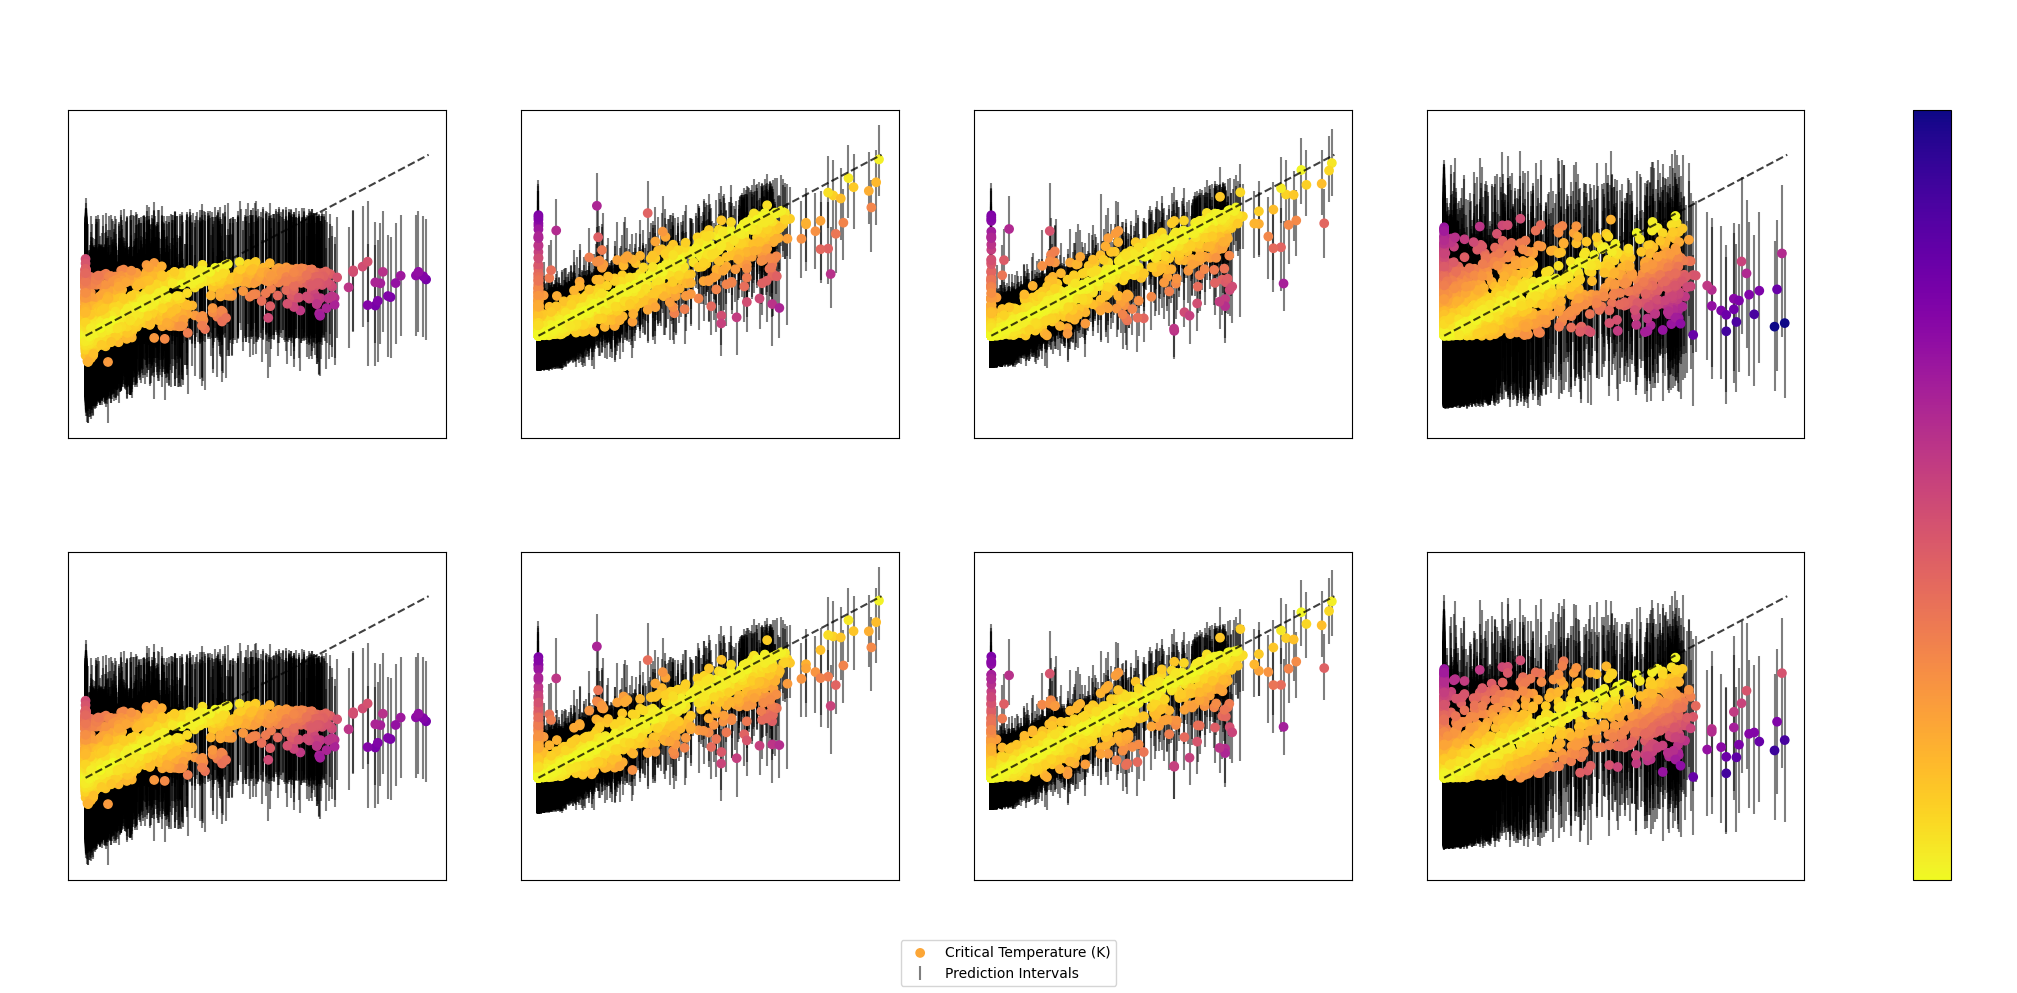

In [59]:
sfn.import_data(replace_inf=True, drop=poor_corr)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Selected Data", filename="results_optimized.png", export=False, forestci=False, method="plus")